In [1]:
import iot_api_client as iot
import datetime
from dateutil.tz import tzutc
import time as tm
import pandas as pd
import matplotlib.pyplot as plt
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

In [2]:
def get_token():
    YOUR_CLIENT_ID = 'LEE2MI2lNlbbZhNs2s1XBPFSXkzZAUhA'
    YOUR_CLIENT_SECRET = 'PIJWDrwgLiSYIopGGR1IjVjsgXrhNQ6R55Hy0nFf0ZZTQhAlXDw4vEppX462eKIZ'

    oauth_client = BackendApplicationClient(client_id=YOUR_CLIENT_ID)
    token_url = "https://api2.arduino.cc/iot/v1/clients/token"

    oauth = OAuth2Session(client=oauth_client)
    token = oauth.fetch_token(
        token_url=token_url,
        client_id=YOUR_CLIENT_ID,
        client_secret=YOUR_CLIENT_SECRET,
        include_client_id=True,
        audience="https://api2.arduino.cc/iot",
    )
    return token
token = get_token()

In [3]:
# Now we setup the iot-api Python client, first of all create a
# configuration object. The access token goes in the config object.
client_config = iot.Configuration(host="https://api2.arduino.cc/iot")
# client_config.debug = True
client_config.access_token = token.get("access_token")

# Create the iot-api Python client with the given configuration
client = iot.ApiClient(client_config)

# Each API model has its own wrapper, here we want to interact with
# devices, so we create a DevicesV2Api object
client_devices = iot.DevicesV2Api(client)
client_things = iot.ThingsV2Api(client)
client_properties = iot.PropertiesV2Api(client)
client_series = iot.SeriesV2Api(client)

# Get a list of devices, catching the specific exception
try:
    devices = client_devices.devices_v2_list()
    things = client_things.things_v2_list()
    print('Response positive.')
except iot.ApiException as e:
    print("An exception occurred: {}".format(e))

for i in range(len(devices)):
    if devices[i].name=='Schantal':
        philipp_device_id = devices[i]

for i in range(len(things)):
    if things[i].name=='DS18B20_Logging_PHILIPP':
        philipp_thing = things[i]

#   Set IDs
device_id = philipp_device_id.id
thing_id = philipp_thing.id
properties = client_properties.properties_v2_list(thing_id)
temp0_id = properties[0].id

#client_devices.devices_v2_timeseries_with_http_info(thing_id, temp0_id, start='2022-11-08T14:00:00Z', limit=100)
to_date_dict = client_properties.properties_v2_timeseries(thing_id, temp0_id)

Response positive.


In [14]:
def get_temp_by_hour(property_id):
    token = get_token()
    client_config = iot.Configuration(host="https://api2.arduino.cc/iot")
    client_config.access_token = token.get("access_token")
    client = iot.ApiClient(client_config)
    client_properties = iot.PropertiesV2Api(client)
    client_things = iot.ThingsV2Api(client)
    try:
        things = client_things.things_v2_list()
        print('Response positive.')
    except iot.ApiException as e:
        print("An exception occurred: {}".format(e))
    for i in range(len(things)):
        if things[i].name=='DS18B20_Logging_PHILIPP':
            philipp_thing = things[i]
    thing_id = philipp_thing.id
    properties = client_properties.properties_v2_list(thing_id)
    to_date_dict = client_properties.properties_v2_timeseries(thing_id, property_id)

    data_list = to_date_dict.data
    times, values = ([] for i in range(2))

    for el in data_list:
        times.append(el.time)
        values.append(el.value)

    df_data = pd.DataFrame({
        'datetime':times,
        'value': values
    })

    df_data['date'] = pd.to_datetime(df_data['datetime']).dt.date
    df_data['time'] = pd.to_datetime(df_data['datetime']).dt.time
    df_data['month'] = pd.to_datetime(df_data['datetime']).dt.month
    df_data['hour'] = pd.to_datetime(df_data['datetime']).dt.hour + pd.to_datetime(df_data['datetime']).dt.minute/60
    return df_data

In [5]:
token = get_token()
client_config = iot.Configuration(host="https://api2.arduino.cc/iot")
client_config.access_token = token.get("access_token")
client = iot.ApiClient(client_config)
client_properties = iot.PropertiesV2Api(client)
client_things = iot.ThingsV2Api(client)
try:
    things = client_things.things_v2_list()
    print('Response positive.')
except iot.ApiException as e:
    print("An exception occurred: {}".format(e))
for i in range(len(things)):
    if things[i].name=='DS18B20_Logging_PHILIPP':
        philipp_thing = things[i]
thing_id = philipp_thing.id
properties = client_properties.properties_v2_list(thing_id)
temp0_id = properties[0].id
to_date_dict = client_properties.properties_v2_timeseries(thing_id, temp0_id)

data_list = to_date_dict.data

Response positive.


Response positive.


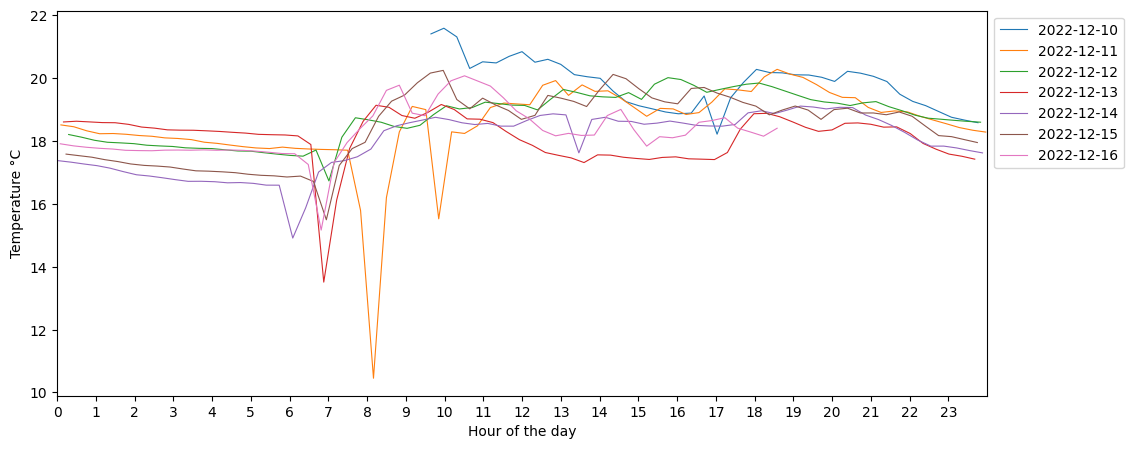

In [13]:
df_data = get_temp_by_hour()

fig, ax = plt.subplots(1, figsize=(12,5))

for date in df_data.date.unique():
    ax.plot(df_data[df_data.date==date]['hour'].values, \
        df_data[df_data.date==date]['value'].values,label=date, \
            lw=.8,)

ax.set_ylabel('Temperature °C')
ax.set_xlabel('Hour of the day')
ax.set_xlim(0, 24)
ax.set_xticks(range(24))
plt.legend(bbox_to_anchor=(1, 1), loc="upper left",  prop={'size': 10})

plt.show()

In [12]:
df_data

,datetime,value,date,time,month,hour
0,2022-12-10 09:39:10+00:00,21.401256,2022-12-10,09:39:10,12,9.650000
1,2022-12-10 09:59:20+00:00,21.581391,2022-12-10,09:59:20,12,9.983333
2,2022-12-10 10:19:30+00:00,21.306069,2022-12-10,10:19:30,12,10.316667
3,2022-12-10 10:39:40+00:00,20.302621,2022-12-10,10:39:40,12,10.650000
4,2022-12-10 10:59:50+00:00,20.513465,2022-12-10,10:59:50,12,10.983333
...,...,...,...,...,...,...
451,2022-12-16 17:14:20+00:00,18.736044,2022-12-16,17:14:20,12,17.233333
452,2022-12-16 17:34:30+00:00,18.403519,2022-12-16,17:34:30,12,17.566667
453,2022-12-16 17:54:40+00:00,18.279637,2022-12-16,17:54:40,12,17.900000
454,2022-12-16 18:14:50+00:00,18.148387,2022-12-16,18:14:50,12,18.233333


In [7]:
data_list

[{'time': datetime.datetime(2022, 12, 10, 9, 39, 10, tzinfo=tzutc()),
  'value': 21.40101809954751},
 {'time': datetime.datetime(2022, 12, 10, 9, 59, 20, tzinfo=tzutc()),
  'value': 21.581390675241156},
 {'time': datetime.datetime(2022, 12, 10, 10, 19, 30, tzinfo=tzutc()),
  'value': 21.306069131832796},
 {'time': datetime.datetime(2022, 12, 10, 10, 39, 40, tzinfo=tzutc()),
  'value': 20.302620967741934},
 {'time': datetime.datetime(2022, 12, 10, 10, 59, 50, tzinfo=tzutc()),
  'value': 20.51346463022508},
 {'time': datetime.datetime(2022, 12, 10, 11, 20, tzinfo=tzutc()),
  'value': 20.478094855305468},
 {'time': datetime.datetime(2022, 12, 10, 11, 40, 10, tzinfo=tzutc()),
  'value': 20.6866961414791},
 {'time': datetime.datetime(2022, 12, 10, 12, 0, 20, tzinfo=tzutc()),
  'value': 20.83608870967742},
 {'time': datetime.datetime(2022, 12, 10, 12, 20, 30, tzinfo=tzutc()),
  'value': 20.500602893890676},
 {'time': datetime.datetime(2022, 12, 10, 12, 40, 40, tzinfo=tzutc()),
  'value': 20.

In [8]:
pd.to_datetime(df_data['datetime']).dt.strftime('%d-%m-%Y')

0      10-12-2022
1      10-12-2022
2      10-12-2022
3      10-12-2022
4      10-12-2022
          ...    
451    16-12-2022
452    16-12-2022
453    16-12-2022
454    16-12-2022
455    16-12-2022
Name: datetime, Length: 456, dtype: object

In [9]:
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import linregress
from numpy import linspace

linreg = linregress(df_data['hour'], df_data['value'])
slope = linreg.slope
incpt = linreg.intercept
r_value = linreg.rvalue
stderr = linreg.stderr
intercept_stderr = linreg.intercept_stderr


xline = linspace(0,df_data['hour'].max())


fig = px.scatter(df_data, x='hour', y='value', \
    color='date', template="simple_white", \
    opacity=.5)

fig.update_traces(marker=dict(size=3, color='black'))

fig.add_trace(go.Scatter(x=xline, y=slope*xline+incpt,
                    mode='lines',
                    name=f'r^2={r_value:.2f}'))

fig.show()

#  Graph per month
fig = px.scatter(df_data, x='hour', y='value', \
    color='month', template="simple_white", \
    opacity=.5)
fig.show()

In [10]:
def revive_connection():
    token = get_token()
    client_config = iot.Configuration(host="https://api2.arduino.cc/iot")
    client_config.access_token = token.get("access_token")
    client = iot.ApiClient(client_config)
    client_properties = iot.PropertiesV2Api(client)
    client_things = iot.ThingsV2Api(client)
    return client_things, client_properties

def get_live_temp(client_things, client_properties):
    try:
        things = client_things.things_v2_list()
        for i in range(len(things)):
            if things[i].name=='DS18B20_Logging_PHILIPP':
                philipp_thing = things[i]
        thing_id = philipp_thing.id
        properties_list = client_properties.properties_v2_list(thing_id)
        temp0_id = properties_list[0].id
        properties_data = client_properties.properties_v2_show(thing_id, temp0_id)
        latest_data = properties_data.last_value
        latest_data_time = properties_data.last_value
        #print('Response positive.')
    except iot.ApiException as e:
        errorlogging = e 
        #print("An exception occurred: {}".format(e))
    return latest_data

In [11]:
import time

client_things, client_properties = revive_connection()

stop_button = False

while stop_button==False:
    start_time = time.time()
    time300 = time.time() - start_time
    client_things, client_properties = revive_connection()
    while time300<30:
        latest_data = get_live_temp(client_things, client_properties)
        print(latest_data)
        time.sleep(3)
        time300 = time.time() - start_time
    print('Token expired, getting a new one.')

18.4375
18.4375
18.4375
18.4375


KeyboardInterrupt: 

In [ ]:
token = get_token()
client_config = iot.Configuration(host="https://api2.arduino.cc/iot")
client_config.access_token = token.get("access_token")
client = iot.ApiClient(client_config)
client_properties = iot.PropertiesV2Api(client)
client_things = iot.ThingsV2Api(client)

things = client_things.things_v2_list()
for i in range(len(things)):
    if things[i].name=='DS18B20_Logging_PHILIPP':
        philipp_thing = things[i]
thing_id = philipp_thing.id
properties_list = client_properties.properties_v2_list(thing_id)
temp0_id = properties_list[0].id
properties_data = client_properties.properties_v2_show(thing_id, temp0_id)
latest_data = properties_data.last_value
latest_data_time = properties_data.last_value
#print('Response positive.')

In [ ]:
from datetime import timedelta
(properties_data.value_updated_at+timedelta(hours=1)).time()

NameError: name 'properties_data' is not defined

1.2